<a href="https://colab.research.google.com/github/silviolima07/Gol/blob/main/Gol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='blue'>Processo Seletivo Gol</font>


In [607]:
import sklearn as sk
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from IPython.core.pylabtools import figsize
from IPython.display import display, HTML
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 200) 
pd.set_option('display.max_rows', 200)
pd.set_option('precision', 2)
import datetime
import gc
import seaborn as sns
from fbprophet import Prophet
import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score
from sklearn import preprocessing

In [608]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Extraindo e Carregando os Dados

In [609]:
# Função que identifica linhas com dados ausentes
# Retorna as linhas e percentuais em cada coluna
#
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[mz_table.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) + " columns that have missing values.")
        return mz_table

In [610]:
# Função que remove dados considerados outliers
# Acima dos limites superiores e inferiores
#
def remove_outlier(df, col):  
    _std = round(df[col].std(), 5)
    _mean= round(df[col].mean(), 5)    
    _min = round(_mean - df[col].std()*3, 5)
    _max = round(_mean + df[col].std()*3, 5)
  
    df.loc[(df[col] < _min) | (df[col] > _max)] = _mean
    df[col] = round(df[col], 5)

## Análise Exploratória de Dados

In [611]:
# Carregando arquivo csv
gol= '/content/drive/MyDrive/Colab Notebooks/Dataset/Gol/case_analytics-ds.csv'


df = pd.read_csv(gol, encoding="latin")

### Estatística Descritiva

In [612]:
df.shape

(2432, 6)

In [613]:
# Visualizando as primeiras linhas
df.head()

,Data Venda,Canal de Venda,Local de Venda,PAX,Monetário Vendido,RPK
0,11/1/2016,Telégrafo,Mindscape,30,"R$ 2,188.11",3476
1,11/1/2016,TeleVenda,Arena,52,"R$ 3,302.38",8197
2,11/1/2016,TeleVenda,Mindscape,19,"R$ 1,041.54",2425
3,11/1/2016,Porta a Porta,Mindscape,496,"R$ 15,566.34",53278
4,11/1/2016,TeleVenda,Vast,46,"R$ 2,721.43",2039


In [614]:
missing_zero_values_table(df)

Your selected dataframe has 6 columns and 2432 Rows.
There are 0 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type


In [615]:
df.isnull().sum()

Data Venda           0
Canal de Venda       0
Local de Venda       0
PAX                  0
Monetário Vendido    0
RPK                  0
dtype: int64

In [616]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2432 entries, 0 to 2431
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Data Venda         2432 non-null   object
 1   Canal de Venda     2432 non-null   object
 2   Local de Venda     2432 non-null   object
 3   PAX                2432 non-null   int64 
 4   Monetário Vendido  2432 non-null   object
 5   RPK                2432 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 114.1+ KB


In [617]:
temp = df['Monetário Vendido'].str.replace('R\$', '')
temp = temp.str.replace(',', '')
df['Monetário Vendido'] = temp
df['Monetário Vendido'] = df['Monetário Vendido'].astype('float64')


In [618]:
df['Data Venda'] = pd.to_datetime(df['Data Venda'], format='%m/%d/%Y')

In [619]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2432 entries, 0 to 2431
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Data Venda         2432 non-null   datetime64[ns]
 1   Canal de Venda     2432 non-null   object        
 2   Local de Venda     2432 non-null   object        
 3   PAX                2432 non-null   int64         
 4   Monetário Vendido  2432 non-null   float64       
 5   RPK                2432 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 114.1+ KB


In [620]:
df['Ano'] = df['Data Venda'].dt.year
#
df['Mês'] = df['Data Venda'].dt.month
#
df['Dia_do_Mês'] = df['Data Venda'].dt.day
#
df['Dia_da_Semana'] = df['Data Venda'].dt.day_name()
df['Dia_da_Semana_Numero'] = df['Data Venda'].dt.dayofweek
df['Nome_do_Dia'] = df['Dia_da_Semana']
df["Nome_do_Dia"].replace({"Sunday": "Domingo", "Monday": "Segunda",
                             "Tuesday": "Terça", "Wednesday": "Quarta",
                             "Thursday": "Quinta", 'Friday': "Sexta",
                             'Saturday': "Sabado"}, inplace=True)
del df['Dia_da_Semana']

In [621]:
df

,Data Venda,Canal de Venda,Local de Venda,PAX,Monetário Vendido,RPK,Ano,Mês,Dia_do_Mês,Dia_da_Semana_Numero,Nome_do_Dia
0,2016-11-01,Telégrafo,Mindscape,30,2188.11,3476,2016,11,1,1,Terça
1,2016-11-01,TeleVenda,Arena,52,3302.38,8197,2016,11,1,1,Terça
2,2016-11-01,TeleVenda,Mindscape,19,1041.54,2425,2016,11,1,1,Terça
3,2016-11-01,Porta a Porta,Mindscape,496,15566.34,53278,2016,11,1,1,Terça
4,2016-11-01,TeleVenda,Vast,46,2721.43,2039,2016,11,1,1,Terça
...,...,...,...,...,...,...,...,...,...,...,...
2427,2017-04-01,Porta a Porta,Vast,1079,28486.40,54551,2017,4,1,5,Sabado
2428,2017-04-01,Porta a Porta,Ellipsis,841,23601.00,46988,2017,4,1,5,Sabado
2429,2017-04-01,TeleVenda,Arena,175,10270.29,26599,2017,4,1,5,Sabado
2430,2017-04-01,Telégrafo,Arena,105,5470.41,15130,2017,4,1,5,Sabado


In [622]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2432 entries, 0 to 2431
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Data Venda            2432 non-null   datetime64[ns]
 1   Canal de Venda        2432 non-null   object        
 2   Local de Venda        2432 non-null   object        
 3   PAX                   2432 non-null   int64         
 4   Monetário Vendido     2432 non-null   float64       
 5   RPK                   2432 non-null   int64         
 6   Ano                   2432 non-null   int64         
 7   Mês                   2432 non-null   int64         
 8   Dia_do_Mês            2432 non-null   int64         
 9   Dia_da_Semana_Numero  2432 non-null   int64         
 10  Nome_do_Dia           2432 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(6), object(3)
memory usage: 209.1+ KB


In [623]:
# Apenas dos valores numéricos
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PAX,2432.0,723.00,735.94,18.00,100.00,395.50,1160.25,4705.00
Monetário Vendido,2432.0,24638.74,22424.84,1041.54,6122.92,17755.42,35535.33,144890.73
RPK,2432.0,66738.39,83479.04,1127.00,11372.00,33361.50,95116.75,695824.00
Ano,2432.0,2016.60,0.49,2016.00,2016.00,2017.00,2017.00,2017.00
Mês,2432.0,5.83,4.71,1.00,2.00,3.00,11.00,12.00
Dia_do_Mês,2432.0,15.53,8.80,1.00,8.00,15.50,23.00,31.00
Dia_da_Semana_Numero,2432.0,3.00,1.98,0.00,1.00,3.00,5.00,6.00


In [624]:
df['RPK'].median()

33361.5

In [625]:
# Contagem por tipo de Canal de Venda
df['Canal de Venda'].value_counts()


TeleVenda        1216
Telégrafo         608
Porta a Porta     608
Name: Canal de Venda, dtype: int64

In [626]:
# Contagem por tipo de Local de Venda
df['Local de Venda'].value_counts()

Ellipsis     608
Mindscape    608
Vast         608
Arena        608
Name: Local de Venda, dtype: int64

In [627]:
# Contagem por Ano
df['Ano'].value_counts()

2017    1456
2016     976
Name: Ano, dtype: int64

In [628]:
# Contagem por Mês
df['Mês'].value_counts()

3     496
1     496
12    496
11    480
2     448
4      16
Name: Mês, dtype: int64

In [629]:
# Contagem por Dia
df['Nome_do_Dia'].value_counts()

Sabado     352
Quarta     352
Sexta      352
Terça      352
Quinta     352
Segunda    336
Domingo    336
Name: Nome_do_Dia, dtype: int64

In [630]:
df.head()

,Data Venda,Canal de Venda,Local de Venda,PAX,Monetário Vendido,RPK,Ano,Mês,Dia_do_Mês,Dia_da_Semana_Numero,Nome_do_Dia
0,2016-11-01,Telégrafo,Mindscape,30,2188.11,3476,2016,11,1,1,Terça
1,2016-11-01,TeleVenda,Arena,52,3302.38,8197,2016,11,1,1,Terça
2,2016-11-01,TeleVenda,Mindscape,19,1041.54,2425,2016,11,1,1,Terça
3,2016-11-01,Porta a Porta,Mindscape,496,15566.34,53278,2016,11,1,1,Terça
4,2016-11-01,TeleVenda,Vast,46,2721.43,2039,2016,11,1,1,Terça


#### Agrupando por Ano

In [631]:
df[['Monetário Vendido', 'Ano']].groupby(by =["Ano"]).sum()

,Monetário Vendido
Ano,
2016,2.33e+07
2017,3.66e+07


#### Agrupando por Mês


In [632]:
df[['Monetário Vendido', 'Mês']].groupby(by =["Mês"]).sum()

,Monetário Vendido
Mês,
1,1.26e+07
2,1.12e+07
3,1.24e+07
4,4.35e+05
11,1.21e+07
12,1.12e+07


#### Agrupando por Canal de Venda

In [633]:
df[['Monetário Vendido', 'Canal de Venda']].groupby(by =["Canal de Venda"]).sum()

,Monetário Vendido
Canal de Venda,
Porta a Porta,1.91e+07
TeleVenda,3.80e+07
Telégrafo,2.79e+06


#### Agrupando por Local de Venda

In [634]:
df[['Monetário Vendido', 'Local de Venda']].groupby(by =["Local de Venda"]).sum()

,Monetário Vendido
Local de Venda,
Arena,1.92e+07
Ellipsis,1.12e+07
Mindscape,1.47e+07
Vast,1.48e+07


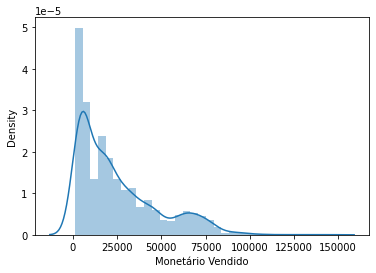

In [635]:
# Distribuição dos dados - histograma
sns.distplot(df['Monetário Vendido']);









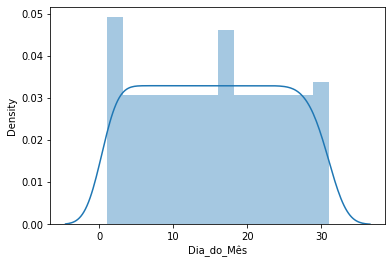

In [636]:
# Distribuição dos dados - histograma
sns.distplot(df['Dia_do_Mês']);

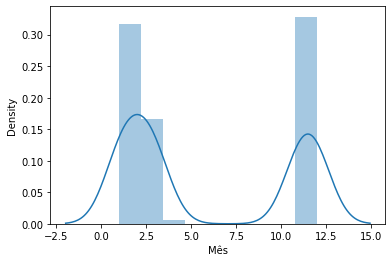

In [637]:
# Distribuição dos dados - histograma
sns.distplot(df['Mês'])

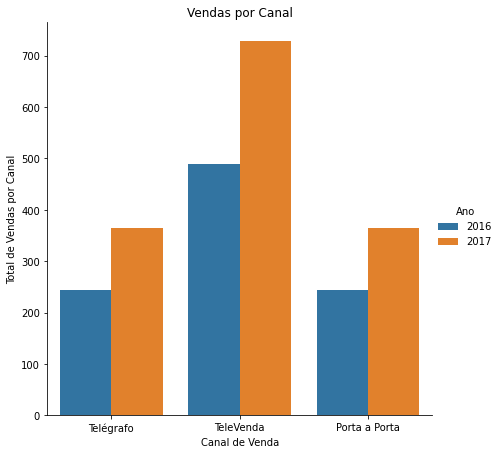

In [638]:
# Total Vendas por Canal
mx = sns.catplot(x = "Canal de Venda", hue = 'Ano', data = df, kind = "count", height = 6)
mx.set(ylabel = 'Total de Vendas por Canal')
plt.title('Vendas por Canal');

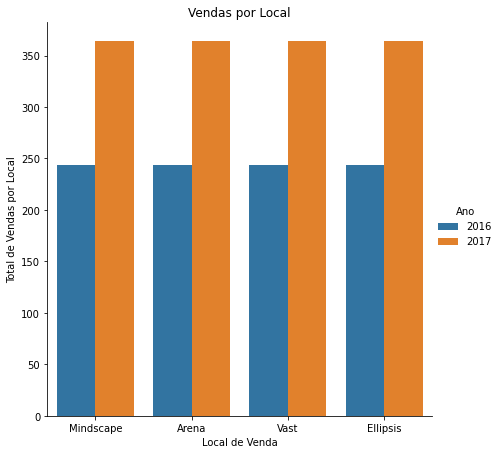

In [639]:
# Total Vendas por Local de Venda
mx = sns.catplot(x = "Local de Venda", hue = 'Ano', data = df, kind = "count", height = 6)
mx.set(ylabel = 'Total de Vendas por Local')
plt.title('Vendas por Local');

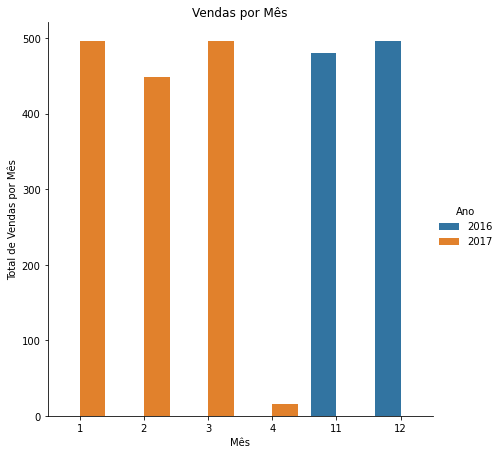

In [640]:
# Total Vendas por Mês
mx = sns.catplot(x = "Mês", hue = 'Ano', data = df, kind = "count", height = 6)
mx.set(ylabel = 'Total de Vendas por Mês')
plt.title('Vendas por Mês');

## Questões
###1-Faça um ranking para o número total de PAX por dia da semana.																	
###2-Qual a correlação de sábado e domingo somados com o total de RPK?																	
###3-Qual a média de ‘Monetário’ por mês por Canal? E a mediana?																	
###4-Crie um forecast de PAX por ‘Local de Venda’ para os próximos 15 dias a contar da última data de venda. (Aqui a técnica é livre) 																	
###5-Supondo que você precisa gerar um estudo para a área responsável, com base em qualquer modelo ou premissa, qual ‘Local de Venda’ você considera mais crítico. Por quê?																	
###6-Criar modelo relacionando o comporatamento de venda com variaveis não apresentada nos dados (Ex : PIB, Dolar, e etc)			

In [641]:
"""
4-Crie um forecast de PAX por ‘Local de Venda’ para os próximos 15 dias a contar da última data de venda. (Aqui a técnica é livre) 																	
5-Supondo que você precisa gerar um estudo para a área responsável, com base em qualquer modelo ou premissa, qual ‘Local de Venda’ você considera mais crítico. Por quê?																	
6-Criar modelo relacionando o comporatamento de venda com variaveis não apresentada nos dados (Ex : PIB, Dolar, e etc)			
"""

'\n4-Crie um forecast de PAX por ‘Local de Venda’ para os próximos 15 dias a contar da última data de venda. (Aqui a técnica é livre) \t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\n5-Supondo que você precisa gerar um estudo para a área responsável, com base em qualquer modelo ou premissa, qual ‘Local de Venda’ você considera mais crítico. Por quê?\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\n6-Criar modelo relacionando o comporatamento de venda com variaveis não apresentada nos dados (Ex : PIB, Dolar, e etc)\t\t\t\n'

### 1 - Faça um ranking para o número total de PAX por dia da semana.

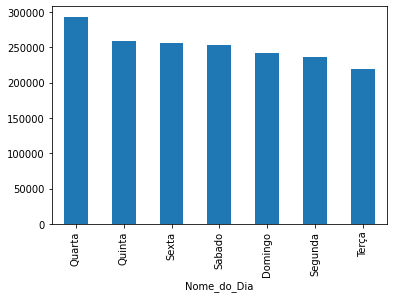

In [642]:
ranking_Dia_PAX = df.groupby(['Nome_do_Dia'])['PAX'].sum().sort_values(ascending=False)
ranking_Dia_PAX.plot(x='Nome_do_Dia', y="PAX", kind= 'bar')

### 2 - Qual a correlação de sábado e domingo somados com o total de RPK?

In [643]:
df_sabado_domingo = df.loc[(df['Nome_do_Dia'] == 'Sabado') | (df['Nome_do_Dia'] == 'Domingo')]

In [644]:
df_sabado_domingo

,Data Venda,Canal de Venda,Local de Venda,PAX,Monetário Vendido,RPK,Ano,Mês,Dia_do_Mês,Dia_da_Semana_Numero,Nome_do_Dia
64,2016-11-05,TeleVenda,Mindscape,1378,60813.49,164710,2016,11,5,5,Sabado
65,2016-11-05,Telégrafo,Ellipsis,42,2695.44,2399,2016,11,5,5,Sabado
66,2016-11-05,TeleVenda,Arena,206,15726.53,32153,2016,11,5,5,Sabado
67,2016-11-05,Porta a Porta,Vast,1314,30005.76,61962,2016,11,5,5,Sabado
68,2016-11-05,Porta a Porta,Mindscape,877,34594.72,98153,2016,11,5,5,Sabado
...,...,...,...,...,...,...,...,...,...,...,...
2427,2017-04-01,Porta a Porta,Vast,1079,28486.40,54551,2017,4,1,5,Sabado
2428,2017-04-01,Porta a Porta,Ellipsis,841,23601.00,46988,2017,4,1,5,Sabado
2429,2017-04-01,TeleVenda,Arena,175,10270.29,26599,2017,4,1,5,Sabado
2430,2017-04-01,Telégrafo,Arena,105,5470.41,15130,2017,4,1,5,Sabado


In [645]:
df[['Dia_da_Semana_Numero', 'RPK']].corr()

,Dia_da_Semana_Numero,RPK
Dia_da_Semana_Numero,1.00e+00,1.34e-04
RPK,1.34e-04,1.00e+00


### 3 - Qual a média de ‘Monetário’ por mês por Canal? E a mediana?	

In [646]:
temp = df.copy()
temp = temp.rename(columns={"Monetário Vendido": "Monetário"})

In [647]:
# Media de Monetário por Mês e Canal de Venda
monet_mean = temp[['Monetário', 'Mês', "Canal de Venda"]].groupby(by =['Mês', "Canal de Venda"]).mean()
#
# Mediana de Monetário por Mês e Canal de Venda
monet_mead = temp[['Monetário', 'Mês', "Canal de Venda"]].groupby(by =['Mês', "Canal de Venda"]).median()

In [648]:
print("Valor da Mediana de Monetário por Mês e Canal de Venda\n\n", monet_mead)

Valor da Mediana de Monetário por Mês e Canal de Venda

                     Monetário
Mês Canal de Venda           
1   Porta a Porta    28823.03
    TeleVenda        19085.12
    Telégrafo         3782.25
2   Porta a Porta    29711.58
    TeleVenda        18926.69
    Telégrafo         4045.89
3   Porta a Porta    30488.19
    TeleVenda        18666.88
    Telégrafo         4345.56
4   Porta a Porta    32421.61
    TeleVenda        28091.89
    Telégrafo         3458.89
11  Porta a Porta    30262.98
    TeleVenda        18757.71
    Telégrafo         4029.14
12  Porta a Porta    25527.52
    TeleVenda        17567.60
    Telégrafo         4227.57


In [649]:
print("Valor da Medio de Monetário por Mês e Canal de Venda\n\n", monet_mean)

Valor da Medio de Monetário por Mês e Canal de Venda

                     Monetário
Mês Canal de Venda           
1   Porta a Porta    31320.57
    TeleVenda        32868.88
    Telégrafo         4234.02
2   Porta a Porta    31710.15
    TeleVenda        32208.45
    Telégrafo         4307.63
3   Porta a Porta    31055.94
    TeleVenda        32132.25
    Telégrafo         4568.15
4   Porta a Porta    33319.50
    TeleVenda        35795.78
    Telégrafo         3778.59
11  Porta a Porta    34638.07
    TeleVenda        30963.46
    Telégrafo         4614.31
12  Porta a Porta    28615.45
    TeleVenda        28045.72
    Telégrafo         5212.65


### 4 - Crie um forecast de PAX por ‘Local de Venda’ para os próximos 15 dias a contar da última data de venda. (Aqui a técnica é livre)

In [650]:
df.head()

,Data Venda,Canal de Venda,Local de Venda,PAX,Monetário Vendido,RPK,Ano,Mês,Dia_do_Mês,Dia_da_Semana_Numero,Nome_do_Dia
0,2016-11-01,Telégrafo,Mindscape,30,2188.11,3476,2016,11,1,1,Terça
1,2016-11-01,TeleVenda,Arena,52,3302.38,8197,2016,11,1,1,Terça
2,2016-11-01,TeleVenda,Mindscape,19,1041.54,2425,2016,11,1,1,Terça
3,2016-11-01,Porta a Porta,Mindscape,496,15566.34,53278,2016,11,1,1,Terça
4,2016-11-01,TeleVenda,Vast,46,2721.43,2039,2016,11,1,1,Terça


In [651]:
df['Local de Venda'].value_counts()

Ellipsis     608
Mindscape    608
Vast         608
Arena        608
Name: Local de Venda, dtype: int64

#### Separando os conjuntos de dados de cada Local de Venda

In [652]:
temp = df.copy()
temp_Mindscape = df.loc[temp['Local de Venda']== "Mindscape"]
#
temp_Arena = df.loc[temp['Local de Venda']== "Arena"]
#
temp_Vast = df.loc[temp['Local de Venda']== "Vast"]
#
temp_Ellipsis = df.loc[temp['Local de Venda']== "Ellipsis"]

#### Forecast dos próximos 15 dias de PAX por Local de Venda, 
#### a partir do última dia de venda.

In [653]:
# Forecast by Prophet
prediction_size = 15 # dias

In [654]:
# A função recebe o local de venda e o conjunto de dados naquele local
# A ultima data de venda no local é extraida selecionado o maior valor no campo Data Venda
# A previsão é definida para um intervalo de confiança~de 95%
# Após o modelo fazer a previsão, é feita filtragem dos 15 dias previstos
# É feito um gráfico que apresenta a evolução do valor de PAX no periodo.
#
# retorna o dataset com as previsões de 15 dias
#
def predict_pax(local,df):
  model = Prophet(interval_width=0.95)
  df = df.rename(columns={"Data Venda": "ds", "PAX": "y"})
  model.fit(df)
  future = model.make_future_dataframe(periods=prediction_size)
  forecast = model.predict(future)
  ultima_venda = df['ds'].max()
  forecast_next_15_days = forecast.loc[forecast.ds > ultima_venda ]
  fig = model.plot(forecast_next_15_days, figsize=(10,5))
  ax = fig.gca()
  ax.set_title(local+"\nForecast by Prophet\nPeriodo: 15 dias a partir da última registrada", size=18)
  ax.set_xlabel("Date", size=14)
  ax.set_ylabel("PAX", size=14)
  ax.tick_params(axis='x', labelsize=10)
  ax.tick_params(axis='y', labelsize=10)
  #
  fig = model.plot_components(forecast, figsize=(10,5))
  return forecast_next_15_days

In [655]:
# A função recebe o local e as previsões, faz ajustes nos nomes das colunas
# E apresentas previsões efetuadas pela lib Prophet
def resultado(local, forecast):
  forecast= forecast.rename(columns={"ds": "Data Venda", "yhat": "PAX"})
  print("\n",local)
  print("\nValores previstos pros próximos 15 dias")
  print("Inicio:",forecast['Data Venda'].min())
  print("Final :", forecast['Data Venda'].max())
  print("\n",forecast[['Data Venda', 'PAX']])

#### Efetuando as previsões para cada local

### Mindscape

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



 Mindcaspe

Valores previstos pros próximos 15 dias
Inicio: 2017-04-02 00:00:00
Final : 2017-04-16 00:00:00

     Data Venda     PAX
152 2017-04-02  655.47
153 2017-04-03  678.82
154 2017-04-04  595.40
155 2017-04-05  778.86
156 2017-04-06  684.70
157 2017-04-07  678.15
158 2017-04-08  673.19
159 2017-04-09  657.35
160 2017-04-10  680.70
161 2017-04-11  597.28
162 2017-04-12  780.74
163 2017-04-13  686.58
164 2017-04-14  680.03
165 2017-04-15  675.07
166 2017-04-16  659.24


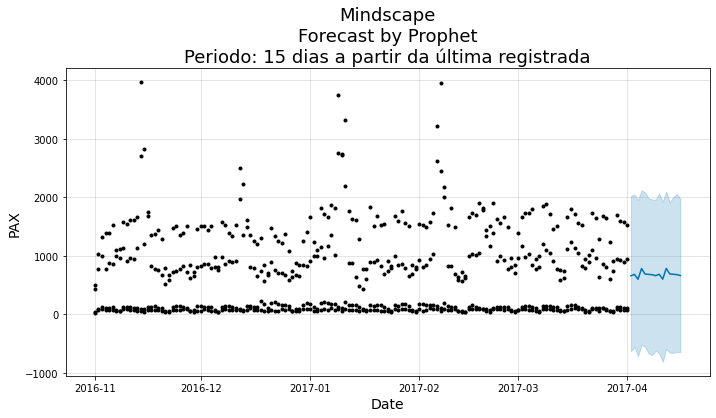

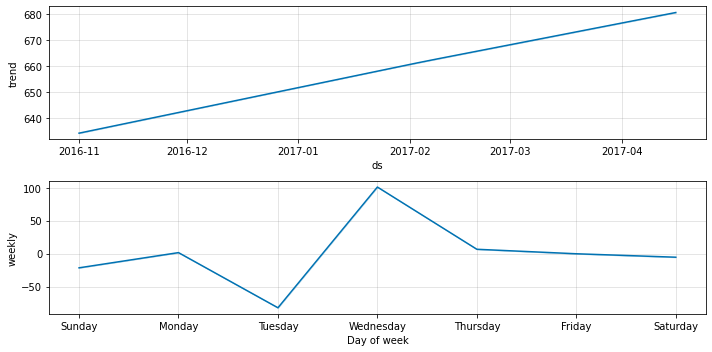

In [656]:
forecast_mindscape = predict_pax('Mindscape',temp_Mindscape);
resultado('Mindcaspe',forecast_mindscape)


### Arena

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



 Arena

Valores previstos pros próximos 15 dias
Inicio: 2017-04-02 00:00:00
Final : 2017-04-16 00:00:00

     Data Venda     PAX
152 2017-04-02  793.23
153 2017-04-03  885.65
154 2017-04-04  682.59
155 2017-04-05  835.99
156 2017-04-06  770.91
157 2017-04-07  767.12
158 2017-04-08  769.12
159 2017-04-09  793.85
160 2017-04-10  886.28
161 2017-04-11  683.22
162 2017-04-12  836.62
163 2017-04-13  771.53
164 2017-04-14  767.75
165 2017-04-15  769.75
166 2017-04-16  794.48


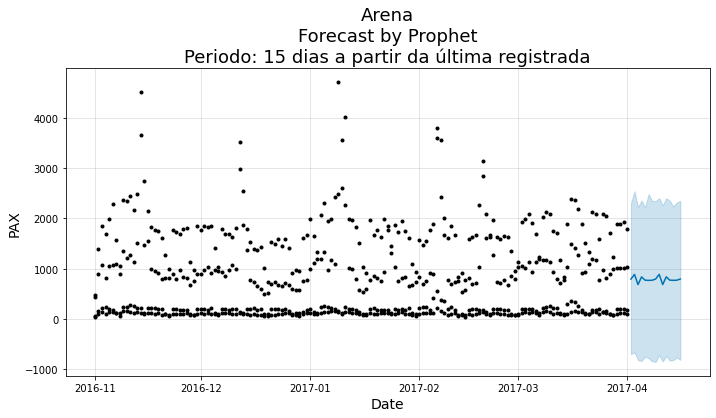

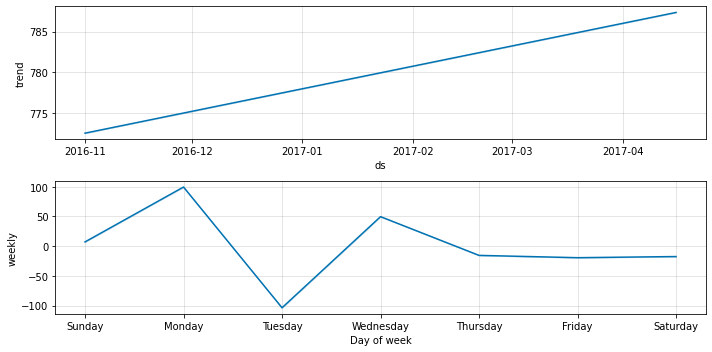

In [657]:
forecast_arena = predict_pax('Arena',temp_Arena);
resultado('Arena',forecast_arena)

### Vast


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



 Vast

Valores previstos pros próximos 15 dias
Inicio: 2017-04-02 00:00:00
Final : 2017-04-16 00:00:00

     Data Venda      PAX
152 2017-04-02   884.68
153 2017-04-03   763.77
154 2017-04-04   754.40
155 2017-04-05  1051.70
156 2017-04-06   921.21
157 2017-04-07   902.84
158 2017-04-08   890.92
159 2017-04-09   888.32
160 2017-04-10   767.40
161 2017-04-11   758.04
162 2017-04-12  1055.33
163 2017-04-13   924.84
164 2017-04-14   906.47
165 2017-04-15   894.55
166 2017-04-16   891.95


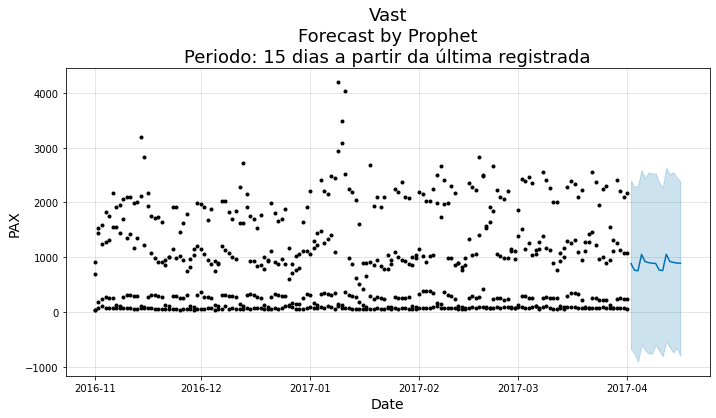

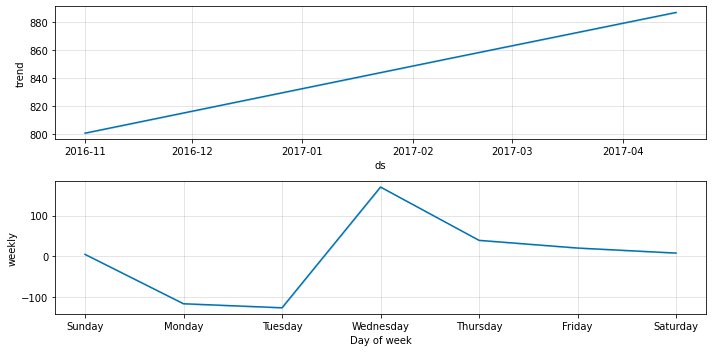

In [658]:
forecast_vast = predict_pax('Vast',temp_Vast);
resultado('Vast',forecast_vast)

### Ellipsis

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



 Ellipsis

Valores previstos pros próximos 15 dias
Inicio: 2017-04-02 00:00:00
Final : 2017-04-16 00:00:00

     Data Venda     PAX
152 2017-04-02  656.69
153 2017-04-03  598.55
154 2017-04-04  584.79
155 2017-04-05  782.61
156 2017-04-06  679.66
157 2017-04-07  675.66
158 2017-04-08  665.83
159 2017-04-09  661.30
160 2017-04-10  603.16
161 2017-04-11  589.39
162 2017-04-12  787.22
163 2017-04-13  684.27
164 2017-04-14  680.26
165 2017-04-15  670.44
166 2017-04-16  665.91


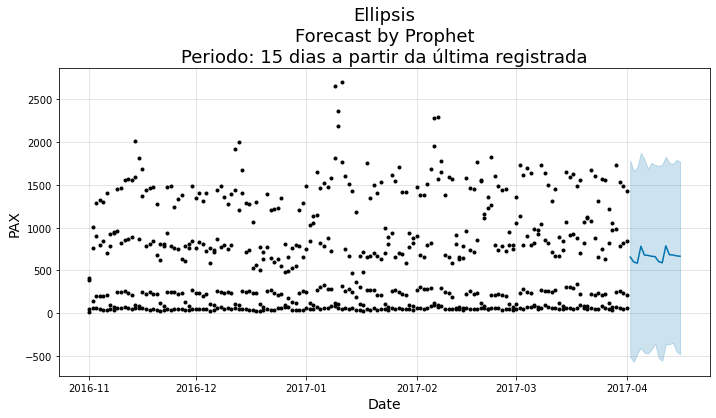

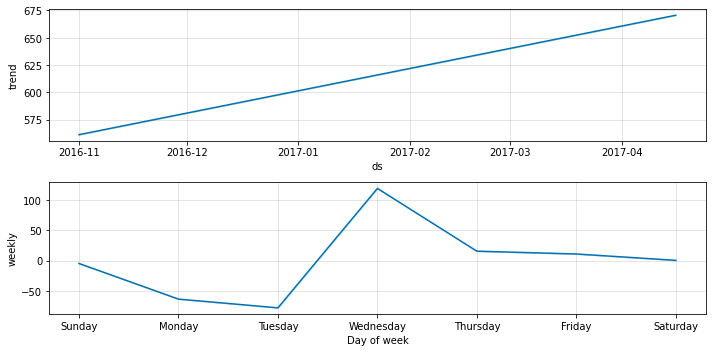

In [659]:
forecast_ellipsis = predict_pax('Ellipsis',temp_Ellipsis);
resultado('Ellipsis',forecast_ellipsis)

In [660]:
mindscape = forecast_mindscape[['ds', 'yhat']].rename(columns={"ds": "Data Venda", "yhat": "PAX_MINDSCAPE"})
arena = forecast_arena[['ds', 'yhat']].rename(columns={"ds": "Data Venda", "yhat": "PAX_ARENA"})
vast = forecast_vast[['ds', 'yhat']].rename(columns={"ds": "Data Venda", "yhat": "PAX_VAST"})
ellipsis = forecast_ellipsis[['ds', 'yhat']].rename(columns={"ds": "Data Venda", "yhat": "PAX_Ellipsis"})

In [661]:
merge1 = pd.merge(vast, arena)
#
merge2 = pd.merge(merge1, mindscape)
#
all_forecast = pd.merge(merge2, ellipsis)


### Previsões para os locais de venda

In [662]:
all_forecast

,Data Venda,PAX_VAST,PAX_ARENA,PAX_MINDSCAPE,PAX_Ellipsis
0,2017-04-02,884.68,793.23,655.47,656.69
1,2017-04-03,763.77,885.65,678.82,598.55
2,2017-04-04,754.40,682.59,595.40,584.79
3,2017-04-05,1051.70,835.99,778.86,782.61
4,2017-04-06,921.21,770.91,684.70,679.66
5,2017-04-07,902.84,767.12,678.15,675.66
6,2017-04-08,890.92,769.12,673.19,665.83
7,2017-04-09,888.32,793.85,657.35,661.30
8,2017-04-10,767.40,886.28,680.70,603.16
9,2017-04-11,758.04,683.22,597.28,589.39


### 5 - Supondo que você precisa gerar um estudo para a área responsável, com base em qualquer modelo ou premissa, qual ‘Local de Venda’ você considera mais crítico. Por quê?

In [663]:
temp_Mindscape.describe().T

,count,mean,std,min,25%,50%,75%,max
PAX,608.0,656.78,690.23,19.00,84.50,327.50,1034.00,3961.00
Monetário Vendido,608.0,24242.94,22567.80,1041.54,5434.19,13115.23,34991.99,94836.67
RPK,608.0,78781.87,84845.12,2425.00,10556.00,35823.00,120343.75,537259.00
Ano,608.0,2016.60,0.49,2016.00,2016.00,2017.00,2017.00,2017.00
Mês,608.0,5.83,4.71,1.00,2.00,3.00,11.00,12.00
Dia_do_Mês,608.0,15.53,8.81,1.00,8.00,15.50,23.00,31.00
Dia_da_Semana_Numero,608.0,3.00,1.99,0.00,1.00,3.00,5.00,6.00


In [664]:
temp_Arena.describe().T

,count,mean,std,min,25%,50%,75%,max
PAX,608.0,780.24,804.76,39.00,121.00,461.00,1264.25,4705.00
Monetário Vendido,608.0,31592.25,27062.72,2249.26,7654.44,21175.89,48186.69,144890.73
RPK,608.0,113754.87,118382.80,5471.00,18211.25,62085.00,180144.50,695824.00
Ano,608.0,2016.60,0.49,2016.00,2016.00,2017.00,2017.00,2017.00
Mês,608.0,5.83,4.71,1.00,2.00,3.00,11.00,12.00
Dia_do_Mês,608.0,15.53,8.81,1.00,8.00,15.50,23.00,31.00
Dia_da_Semana_Numero,608.0,3.00,1.99,0.00,1.00,3.00,5.00,6.00


In [665]:
temp_Vast.describe().T

,count,mean,std,min,25%,50%,75%,max
PAX,608.0,839.90,823.41,40.00,96.00,429.00,1330.75,4191.00
Monetário Vendido,608.0,24273.38,21818.45,1497.62,5267.68,18908.01,30509.54,92007.17
RPK,608.0,39919.86,39204.33,1932.00,4551.25,20010.00,63788.25,209750.00
Ano,608.0,2016.60,0.49,2016.00,2016.00,2017.00,2017.00,2017.00
Mês,608.0,5.83,4.71,1.00,2.00,3.00,11.00,12.00
Dia_do_Mês,608.0,15.53,8.81,1.00,8.00,15.50,23.00,31.00
Dia_da_Semana_Numero,608.0,3.00,1.99,0.00,1.00,3.00,5.00,6.00


In [666]:
temp_Ellipsis.describe().T

,count,mean,std,min,25%,50%,75%,max
PAX,608.0,615.08,577.93,18.00,78.00,334.50,953.25,2697.00
Monetário Vendido,608.0,18446.39,14460.58,1126.69,4383.74,16457.54,25017.52,60758.26
RPK,608.0,34496.96,32220.57,1127.00,4579.00,19990.50,53505.75,152788.00
Ano,608.0,2016.60,0.49,2016.00,2016.00,2017.00,2017.00,2017.00
Mês,608.0,5.83,4.71,1.00,2.00,3.00,11.00,12.00
Dia_do_Mês,608.0,15.53,8.81,1.00,8.00,15.50,23.00,31.00
Dia_da_Semana_Numero,608.0,3.00,1.99,0.00,1.00,3.00,5.00,6.00


#### Distribuição dos dados em cada Local de Venda

#### - Mindscape

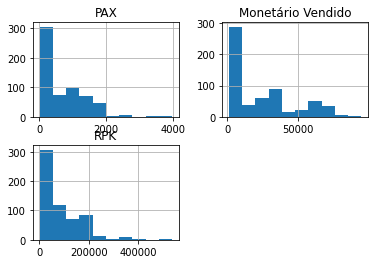

In [667]:
temp_Mindscape[['PAX', 'Monetário Vendido', 'RPK']].hist();

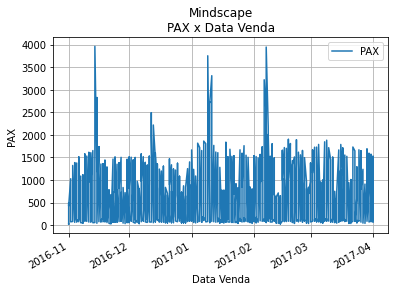

In [668]:
Mindscape_pax=temp_Mindscape[['PAX','Data Venda']]
(Mindscape_pax.set_index(['Data Venda'])).plot();
plt.title("Mindscape\nPAX x Data Venda")
plt.xlabel("Data Venda"), plt.ylabel("PAX"), plt.grid(b=True);

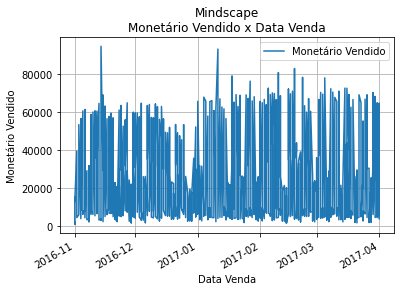

In [669]:
Mindscape_Monetario=temp_Mindscape[['Monetário Vendido','Data Venda']]
(Mindscape_Monetario.set_index(['Data Venda'])).plot();
plt.title("Mindscape\nMonetário Vendido x Data Venda")
plt.xlabel("Data Venda"), plt.ylabel("Monetário Vendido"), plt.grid(b=True);

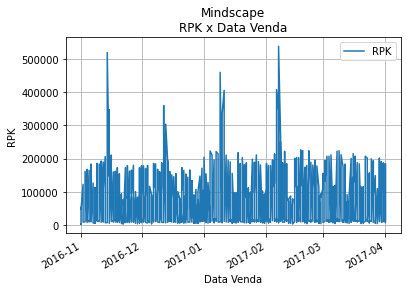

In [670]:
Mindscape_rpk=temp_Mindscape[['RPK','Data Venda']]
(Mindscape_rpk.set_index(['Data Venda'])).plot();
plt.title("Mindscape\nRPK x Data Venda")
plt.xlabel("Data Venda"), plt.ylabel("RPK"), plt.grid(b=True);

#### - Arena

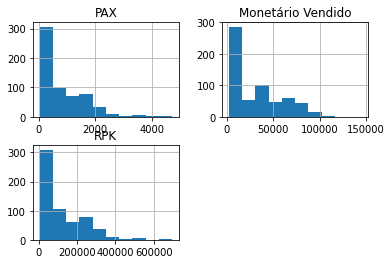

In [671]:
temp_Arena[['PAX', 'Monetário Vendido', 'RPK']].hist();

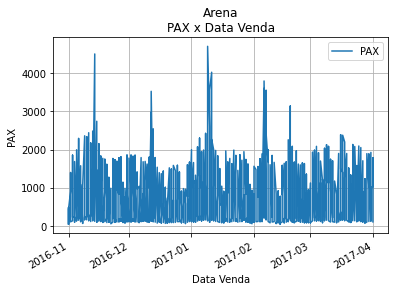

In [672]:
Arena_pax=temp_Arena[['PAX','Data Venda']]
(Arena_pax.set_index(['Data Venda'])).plot();
plt.title("Arena\nPAX x Data Venda")
plt.xlabel("Data Venda"), plt.ylabel("PAX"), plt.grid(b=True);

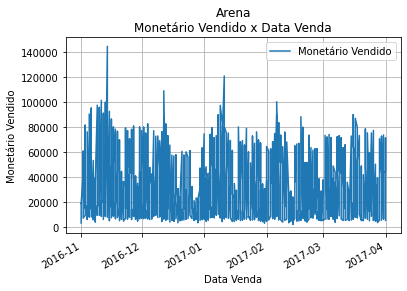

In [673]:
Arena_Monetario=temp_Arena[['Monetário Vendido','Data Venda']]
(Arena_Monetario.set_index(['Data Venda'])).plot();
plt.title("Arena\nMonetário Vendido x Data Venda")
plt.xlabel("Data Venda"), plt.ylabel("Monetário Vendido"), plt.grid(b=True);

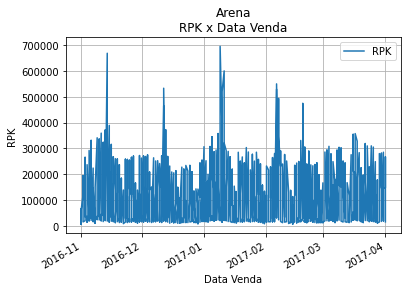

In [674]:
Arena_rpk=temp_Arena[['RPK','Data Venda']]
(Arena_rpk.set_index(['Data Venda'])).plot();
plt.title("Arena\nRPK x Data Venda")
plt.xlabel("Data Venda"), plt.ylabel("RPK"), plt.grid(b=True);

#### - Vast

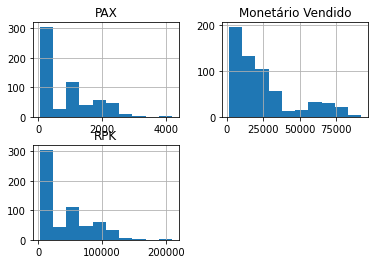

In [675]:
temp_Vast[['PAX', 'Monetário Vendido', 'RPK']].hist();

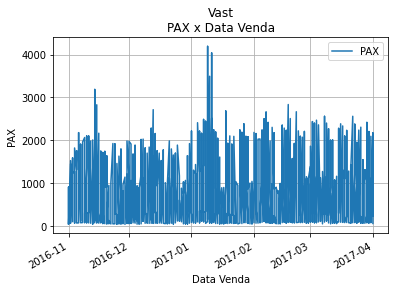

In [676]:
Vast_pax=temp_Vast[['PAX','Data Venda']]
(Vast_pax.set_index(['Data Venda'])).plot();
plt.title("Vast\nPAX x Data Venda")
plt.xlabel("Data Venda"), plt.ylabel("PAX"), plt.grid(b=True);

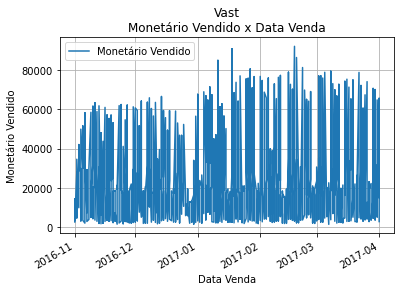

In [677]:
Vast_Monetario=temp_Vast[['Monetário Vendido','Data Venda']]
(Vast_Monetario.set_index(['Data Venda'])).plot();
plt.title("Vast\nMonetário Vendido x Data Venda")
plt.xlabel("Data Venda"), plt.ylabel("Monetário Vendido"), plt.grid(b=True);

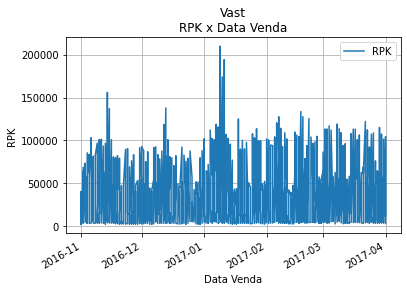

In [678]:
Vast_rpk=temp_Vast[['RPK','Data Venda']]
(Vast_rpk.set_index(['Data Venda'])).plot();
plt.title("Vast\nRPK x Data Venda")
plt.xlabel("Data Venda"), plt.ylabel("RPK"), plt.grid(b=True);

#### - Ellipsis

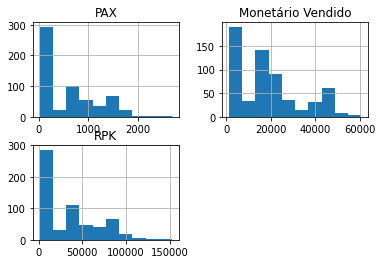

In [679]:
temp_Ellipsis[['PAX', 'Monetário Vendido', 'RPK']].hist();

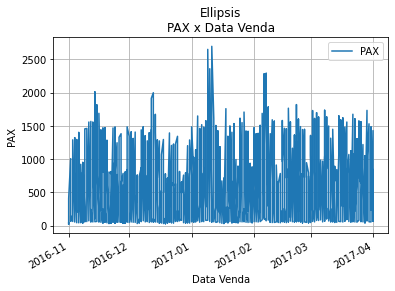

In [680]:
Ellipsis_pax=temp_Ellipsis[['PAX','Data Venda']]
(Ellipsis_pax.set_index(['Data Venda'])).plot();
plt.title("Ellipsis\nPAX x Data Venda")
plt.xlabel("Data Venda"), plt.ylabel("PAX"), plt.grid(b=True);

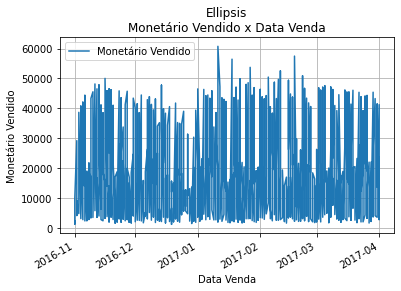

In [587]:
Ellipsis_Monetario=temp_Ellipsis[['Monetário Vendido','Data Venda']]
(Ellipsis_Monetario.set_index(['Data Venda'])).plot();
plt.title("Ellipsis\nMonetário Vendido x Data Venda")
plt.xlabel("Data Venda"), plt.ylabel("Monetário Vendido"), plt.grid(b=True);

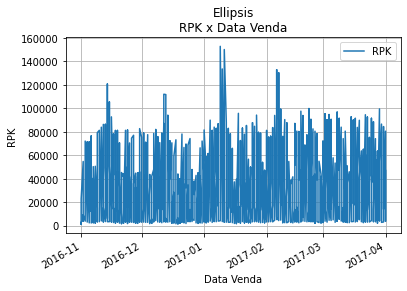

In [588]:
Ellipsis_rpk=temp_Ellipsis[['RPK','Data Venda']]
(Ellipsis_rpk.set_index(['Data Venda'])).plot();
plt.title("Ellipsis\nRPK x Data Venda")
plt.xlabel("Data Venda"), plt.ylabel("RPK"), plt.grid(b=True);

### Todos conjuntos de dados apresentam grande variação
### Analisando: PAX, Monetário Vendido e RPK, foram encontrados altos valores de desvio padrão (std) que podem influenciar nos resultados da análise. A distribuição dos dados em cada conjunto também influência, pois alguns algoritmos esperam os dados numa forma normal.
### Alguns algoritmos são baseados em distância (svm, knn, regressões lineares e não lineares, kmeans, redes neurais, etc) são bastante sensíveis a variações de distância, justamente porque os algoritmos apresentam cálculos de distância. Já todos os que são de árvores de decisão simplesmente comparam (através de regras), sem levar em conta cálculos de distâncias e, assim não precisam de normalização.
### O conjunto de dados de Arena apresenta um alto desvio padrão e de acordo com o algoritmo usado pode ser considerado o mais critico, pois irá impactar nos resultados finais. 

### 6 - Criar modelo relacionando o comportamento de venda com variaveis não apresentada nos dados (Ex : PIB, Dolar, e etc)

### Incluindo a cotação do Dolar no periodo do dataset
#### A cotação foi feita através do site: 
#### https://olinda.bcb.gov.br/olinda/servico/PTAX/versao/v1/aplicacao#!/recursos

In [589]:
dollar=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/Gol/cotacao_dollar.csv", decimal=",")

In [590]:
dollar['Data Venda'] = pd.to_datetime(dollar['dataHoraCotacao'])
dollar['Data Venda'] = dollar['Data Venda'].dt.strftime('%Y-%m-%d')
dollar['Data Venda'] = pd.to_datetime(df['Data Venda'], format='%m/%d/%Y')
del dollar['dataHoraCotacao']

In [591]:
df2 = pd.merge(df, dollar)

In [592]:
df2.head()

,Data Venda,Canal de Venda,Local de Venda,PAX,Monetário Vendido,RPK,Ano,Mês,Dia_do_Mês,Dia_da_Semana_Numero,Nome_do_Dia,cotacaoCompra
0,2016-11-01,Telégrafo,Mindscape,30,2188.11,3476,2016,11,1,1,Terça,4.01
1,2016-11-01,Telégrafo,Mindscape,30,2188.11,3476,2016,11,1,1,Terça,4.03
2,2016-11-01,Telégrafo,Mindscape,30,2188.11,3476,2016,11,1,1,Terça,3.99
3,2016-11-01,Telégrafo,Mindscape,30,2188.11,3476,2016,11,1,1,Terça,4.02
4,2016-11-01,Telégrafo,Mindscape,30,2188.11,3476,2016,11,1,1,Terça,4.04


In [593]:
df2 = df2.drop(['Data Venda'], axis = 1)

In [594]:
temp = df2.copy()
temp_Mindscape = df2.loc[temp['Local de Venda']== "Mindscape"]
df2_Mindscape = temp_Mindscape.copy()
#
temp_Arena = df2.loc[temp['Local de Venda']== "Arena"]
df2_Arena = temp_Arena.copy()
#
temp_Vast = df2.loc[temp['Local de Venda']== "Vast"]
df2_Vast = temp_Vast.copy()
#
temp_Ellipsis = df2.loc[temp['Local de Venda']== "Ellipsis"]
df2_Ellipsis = temp_Ellipsis.copy()

In [595]:
le = preprocessing.LabelEncoder()

In [596]:
objList = df2.select_dtypes(include = "object").columns

In [597]:
objList

Index(['Canal de Venda', 'Local de Venda', 'Nome_do_Dia'], dtype='object')

In [598]:
for feat in objList:
    df2_Mindscape[feat] = le.fit_transform(temp_Mindscape[feat].astype(str))
    df2_Arena[feat] = le.fit_transform(temp_Arena[feat].astype(str))
    df2_Vast[feat] = le.fit_transform(temp_Vast[feat].astype(str))
    df2_Ellipsis[feat] = le.fit_transform(temp_Ellipsis[feat].astype(str))

In [599]:
df2_Mindscape.head()

,Canal de Venda,Local de Venda,PAX,Monetário Vendido,RPK,Ano,Mês,Dia_do_Mês,Dia_da_Semana_Numero,Nome_do_Dia,cotacaoCompra
0,2,0,30,2188.11,3476,2016,11,1,1,6,4.01
1,2,0,30,2188.11,3476,2016,11,1,1,6,4.03
2,2,0,30,2188.11,3476,2016,11,1,1,6,3.99
3,2,0,30,2188.11,3476,2016,11,1,1,6,4.02
4,2,0,30,2188.11,3476,2016,11,1,1,6,4.04


## Treinamento e avaliação do modelo

In [600]:
data_train = df2_Mindscape


In [601]:
# Função que recebe os dados do Local de Venda, separa as variaveis independentes (X) 
# da variavel dependente (y). É feito um split em dados de treino e teste.
# Os dados de treino passam pelo treino e transformação. Os modelos são treinado
# usando normalized_x_train e y_train.
# Antes da previsão com o modelo treinado, os dados de teste, x_test recebe a transformação aplicada
# aos dados de treinamento.
# A performance dos modelos é feita através do Coeficiente de Determinação - R2
#
def run_model(local,df):
    print("Local de Venda:", local,"\n")   
    nome_alg = ['RandomForestRegressor', 'DecisionTreeRegressor', 'KNeighborsRegressor', 'ExtraTreesRegressor']
    modelos = [RandomForestRegressor(n_estimators=250),DecisionTreeRegressor(), KNeighborsRegressor(), ExtraTreesRegressor(n_estimators=150)]
    
    # Separando dados e target
    X = df.drop(['Monetário Vendido'], axis=1)
    y = df['Monetário Vendido']

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

    scaler = StandardScaler()

    normalized_x_train = pd.DataFrame(scaler.fit_transform(x_train), columns = x_train.columns)
    
    # Fit do modelo
    for i in range(len(modelos)):
        modelos[i].fit(normalized_x_train, y_train)

    normalized_x_test = pd.DataFrame(scaler.transform(x_test), columns = x_test.columns)
     
    # Predição no dataset de treino
    preds=[]
    for i in range(len(modelos)):
        preds.append(modelos[i].predict(normalized_x_test))
    
    # Exibir o relatorio do modelo
    algoritmo=[]
    previsoes=[]
    for i in range(len(preds)):
        print("Modelo: ", nome_alg[i],"--> R2 : %.4g" % r2_score(y_test, preds[i]))
        algoritmo.append(nome_alg[i])
        previsoes.append(r2_score(y_test, preds[i]))
    return ([local, algoritmo, previsoes])

In [602]:

out1 = run_model('Mindscape', df2_Mindscape)

Local de Venda: Mindscape 

Modelo:  RandomForestRegressor --> R2 : 0.9999
Modelo:  DecisionTreeRegressor --> R2 : 0.9999
Modelo:  KNeighborsRegressor --> R2 : 0.9998
Modelo:  ExtraTreesRegressor --> R2 : 1


In [603]:

out2 = run_model('Arena', df2_Arena)

Local de Venda: Arena 

Modelo:  RandomForestRegressor --> R2 : 1
Modelo:  DecisionTreeRegressor --> R2 : 0.9999
Modelo:  KNeighborsRegressor --> R2 : 1
Modelo:  ExtraTreesRegressor --> R2 : 1


In [604]:

out3  = run_model('Vast', df2_Vast)

Local de Venda: Vast 

Modelo:  RandomForestRegressor --> R2 : 1
Modelo:  DecisionTreeRegressor --> R2 : 0.9999
Modelo:  KNeighborsRegressor --> R2 : 0.9993
Modelo:  ExtraTreesRegressor --> R2 : 1


In [605]:

out4 = run_model('Ellipsis', df2_Ellipsis)

Local de Venda: Ellipsis 

Modelo:  RandomForestRegressor --> R2 : 1
Modelo:  DecisionTreeRegressor --> R2 : 1
Modelo:  KNeighborsRegressor --> R2 : 0.9996
Modelo:  ExtraTreesRegressor --> R2 : 1


In [606]:
data = { 'local': [out1[0],out1[0],out1[0],out1[0],
                   out2[0],out2[0],out2[0],out2[0],
                   out3[0],out3[0],out3[0],out3[0],
                   out4[0],out4[0],out4[0],out4[0]],
        
         'modelo': [out1[1][0], out1[1][1], out1[1][2], out1[1][3],
                    out2[1][1], out2[1][1], out2[1][2], out2[1][3],
                    out3[1][0], out3[1][1], out3[1][2], out3[1][3],
                    out4[1][0], out4[1][1], out4[1][2], out4[1][3]],
        
        'R2': [out1[2][0],out1[2][1], out1[2][2], out1[2][3],
              out2[2][0],out2[2][1], out2[2][2], out2[2][3],
              out3[2][0],out3[2][1], out3[2][2], out3[2][3],
              out4[2][0],out4[2][1], out4[2][2], out4[2][3]]}        
      
df_previsoes = pd.DataFrame(data, columns=['local', 'modelo', 'R2'])
df_previsoes

,local,modelo,R2
0,Mindscape,RandomForestRegressor,1.0
1,Mindscape,DecisionTreeRegressor,1.0
2,Mindscape,KNeighborsRegressor,1.0
3,Mindscape,ExtraTreesRegressor,1.0
4,Arena,DecisionTreeRegressor,1.0
5,Arena,DecisionTreeRegressor,1.0
6,Arena,KNeighborsRegressor,1.0
7,Arena,ExtraTreesRegressor,1.0
8,Vast,RandomForestRegressor,1.0
9,Vast,DecisionTreeRegressor,1.0
